## TOC:
* [fasttext](#fasttext)
* [summarization](#Summarization)
* [doc2vec](#doc2vec)
* [plots](#Plots)

In [50]:
import pandas as pd
import numpy as np
import gensim
import nltk
import json

import scipy
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

from summa import summarizer
from many_stop_words import get_stop_words

In [2]:
df = pd.read_csv("DATASET.csv.gz", compression="gzip")

In [3]:
df.head()

,labels,lemmas,name,number,source,text
0,NaN,школа злословие учить прикусывать язык сохраня...,00021 Школа злословия,NaN,opencorpora,«Школа злословия» учит прикусить язык Сохранит...
1,NaN,последний восстание сеул международный биеннал...,00022 Последнее восстание в Сеуле,NaN,opencorpora,«Последнее восстание» в Сеуле Международная би...
2,NaN,отвечать дэвид лисс популярный автор историчес...,00023 За кота - ответишь!,NaN,opencorpora,"За кота – ответишь! Дэвид Лисс, популярный авт..."
3,NaN,быстротечный кинороман отечественный кинематог...,00024 Быстротечный кинороман,NaN,opencorpora,Быстротечный кинороман Отечественные кинематог...
4,NaN,холодный ванна возвращать сила гидротерапия сч...,00014 Холодная ванна возвращает силы,NaN,opencorpora,Холодная ванна возвращает силы Гидротерапия: с...


# fasttext

Разделяем тексты на предложения с максимальным количеством слов в одном = 500

In [40]:
def split_sent(text, min_len=3, max_len=500):
    res = []
    for sent in nltk.sent_tokenize(text):
        sent = sent.split()
        if len(sent) < max_len and len(sent) > min_len:
            res.append(" ".join(sent))
    return res

In [ ]:
res = []
for i, row in df.iterrows():
    sents = split_sent(row['text'])
    if sents:
        for sent in sents:
            res.append({
              "labels": row["labels"], 
              "name": row["name"],
              "number": row["number"],
              "source": row["source"],
              "sent": sent
            })

s = pd.DataFrame(res)

Создаем из предложений корпус

In [54]:
gensim.utils.save_as_line_sentence(s['sent'].str.split(), 'all/tmp_sent.txt')

In [74]:
!head all/tmp_sent.txt

«Школа злословия» учит прикусить язык Сохранится ли градус дискуссии в новом сезоне?
Великолепная «Школа злословия» вернулась в эфир после летних каникул в новом формате.
В истории программы это уже не первый «ребрендинг».
Сейчас с трудом можно припомнить, что начиналась «Школа…» на канале «Культура» как стандартное ток-шоу, которое отличалось от других «кухонными» обсуждениями гостя, что называется – «за глаза», и неожиданными персонами в качестве ведущих.
Писательница Татьяна Толстая и сценаристка Дуня Смирнова вроде бы не вполне соответствовали принятым на российском телевидении стандартам телеведущих.
Впрочем, на канале «Культура» в роли телеведущих выступают и писатели, и композиторы, так что в этом ничего сверхъестественного не было, а идея кухонных обсуждений не слишком прижилась, и некоторые выпуски программы обходились практически без них.
В остальном «Школа злословия» представляла собой интервью ведущих с героем выпуска.
Иногда и в самом деле не без злословия, а по большей ча

Обучаем модель

In [56]:
fasttext = gensim.models.FastText(corpus_file='all/tmp_sent.txt', size=300)

Для каждого предложения нормализуем и усредняем эмбеддинги слов, входящих в него

In [ ]:
def normalize(arr):
    return np.array(arr) / np.linalg.norm(arr)

def sent_emb(text, model=fasttext):
    """Returns mean embedding vector of all word embedding vectors in text"""
    res = []
    for w in text.split():
        if w in model.wv:
            res.append(normalize(model.wv[w]))
    return np.mean(res, axis=0)

In [72]:
%%time
s['fasttext'] = s['sent'].map(sent_emb)

100%|██████████| 2065547/2065547 [11:37<00:00, 2961.36it/s]


Выбираем отдельно только предложения УК РФ и только Судебные акты по уголовным делам

In [174]:
cc = s[s['source'] == 'criminal_code']
co = s[s['source'] == 'criminal_court_orders']

Создаем k-мерное дерево из векторов предложений кодекса УК РФ для быстрого поиска ближайших соседей

In [175]:
cc_space = scipy.spatial.KDTree(cc['fasttext'].tolist())

Сгруппируем судебные акты так, чтобы одному акту соответствовал массив эмбеддингов его предложений

In [176]:
co = (
    co.groupby("name")
    .agg({
        "labels": "first", 
        "source": "first", 
        "sent": lambda x: " ".join(x), 
        "fasttext": list})
    .reset_index(drop=True)
)

Задаём функцию поиска ближайших k предложений из УК РФ для Судебного акта.

Для каждого предложения в тексте судебного акта находим ближайшие k статей, затем все найденные статьи УК сортируются по нескольким параметрам:
- Суммарное количество раз, которое эта статья была встречена -> max
- Суммарное расстояние до этой статьи -> min
- Суммарный ранк (порядковый номер) этой статьи в листах -> max

In [228]:
def find_nearest_articles(vectors, k):
    """
    vectors - массив эмбеддингов предложений
    k - количество статей 
    """
    def find_nearest_by_sent():
        res = []
        for vec in vectors:
            dist, idx = cc_space.query(vec, k=k)
            articles = cc.iloc[idx]["number"].tolist()
            res += [
                {"article": a, "rank": r, "dist": d, "count": 1}
                for r, (a, d) in enumerate(zip(articles, dist))
            ]
        return res
    
    near = (
        pd.DataFrame(find_nearest_by_sent())
        .groupby("article")
        .agg({"count": "sum", "dist": "sum", "rank": "sum"})
        .reset_index(drop=False)
        .sort_values(by=["count", "dist","rank"], ascending=[False, True, True])
    )["article"][:k].tolist()
    return near

In [229]:
print("Найденные ближайшие статьи", find_nearest_articles(co.iloc[0].fasttext, k=5))
print("Реальные статьи", co.iloc[0].labels)

Найденные ближайшие статьи [79.0, 63.1, 134.0, 80.0, 102.0]
Реальные статьи 119.0 25.0


Возьмем небольшую выборку текстов

In [207]:
co_sample = co.sample(100).copy().reset_index(drop=True)

In [210]:
%%time
co_sample['near'] = co_sample['fasttext'].map(lambda x: find_nearest_articles(x, 5))

CPU times: user 1min 45s, sys: 716 ms, total: 1min 46s
Wall time: 1min 46s


In [246]:
co_sample.head()

,labels,source,sent,fasttext,near
0,158.0 25.0 76.0,criminal_court_orders,Органами предварительного следствия Мифтахутди...,"[[0.044037003, 0.05727614, -0.03961829, -0.011...","[79.0, 63.1, 178.0, 204.1, 80.0]"
1,228.0 73.0,criminal_court_orders,Харитонюк Р. В. совершил незаконные приобретен...,"[[0.013572665, 0.03016867, -0.006710998, -0.02...","[79.0, 264.0, 60.0, 63.1, 69.0]"
2,317.0,criminal_court_orders,совершил неуплату родителем без уважительных п...,"[[-0.006112484, 0.023630816, -0.0024741322, -0...","[79.0, 264.0, 102.0, 60.0, 69.0]"
3,264.1 317.0,criminal_court_orders,<ФИО4> постановлением мирового судьи судебного...,"[[-0.009600391, 0.020182408, 0.009267622, -0.0...","[79.0, 264.0, 102.0, 60.0, 69.0]"
4,158.0 161.0 158.0 166.0 158.0 317.0,criminal_court_orders,ФИО1 совершил умышленное преступление против с...,"[[0.005743494, 0.052958693, -0.013303235, -0.0...","[79.0, 63.1, 15.0, 82.1, 82.0]"


## Summarization

Summarize all texts by `textrank` algorithm 

In [4]:
def summ_text(text, ratio=0.25, stopwords=get_stop_words("ru"), language="russian"):
    return summarizer.summarize(
        text, ratio=ratio, 
        language=language, 
        additional_stopwords=stopwords
    )

We continue work only with articles from criminal code and criminal court orders.

In [5]:
ds = df[df['source'].isin(["criminal_code", "criminal_court_orders"])].copy().reset_index(drop=True)

In [6]:
ds['summ'] = ds['text'].map(summ_text)

In [7]:
ds.to_csv("summ_data.csv.gz", compression="gzip", index=False)

Empty results replaces with text itself

In [13]:
ds['summ'] = ds.apply(lambda row: row['text'] if row['summ'] == '' else row['summ'], axis=1)

Remove \n, \r and multiple spaces from texts:

In [25]:
ds['summ'] = ds['summ'].str.split().map(lambda x: " ".join(x))

Split summarized texts on sentences

In [43]:
res = []
for i, row in ds.iterrows():
    sents = split_sent(row['summ'])
    if sents:
        for sent in sents:
            res.append({
              "labels": row["labels"], 
              "name": row["name"],
              "number": row["number"],
              "source": row["source"],
              "sent": sent
            })

s = pd.DataFrame(res)

In [277]:
import tempfile
import numpy as np
import gensim


class FastTextEmbedding:
    def __init__(self):
        pass

    def train(self, sentences: list, model_path=None, corpus_path=None, **kwargs):
        """Create fasttext model and save to `model_path` (or to tmpfile by default)"""

        def make_corpus():
            self.corpus_path = corpus_path
            if not self.corpus_path:
                _, self.corpus_path = tempfile.mkstemp()
            gensim.utils.save_as_line_sentence(sentences, self.corpus_path)
            print("created corpus at {}".format(self.corpus_path))
            return self.corpus_path

        self.model_path = model_path
        if not self.model_path:
            _, self.model_path = tempfile.mkstemp()

        print("start training")
        self.model = gensim.models.FastText(corpus_file=make_corpus(), **kwargs)
        print("training complete")
        print("saving model to {}".format(model_path))
        self.model.save(model_path)
        print("done")
        return self

    def sent_emb(self, sentence: str):
        """Returns mean embedding vector of all word embedding vectors in text"""

        def normalize(arr):
            return np.array(arr) / np.linalg.norm(arr)

        res = [
            normalize(self.model.wv[word])
            for word in sentence.split()
            if word in self.model.wv
        ]
        return np.mean(res, axis=0)

    def load_model(self, fname):
        self.model = gensim.models.FastText.load(fname)
        print("model loaded")
        return self

In [ ]:
# %%capture train_output
# %%time

ft_emb = FastTextEmbedding().train(
    sentences=s["sent"].str.split().tolist(),
    model_path="fasttext.model",
    corpus_path="fasttext.corpus",
    size=300,
#     word_ngrams=1,
    iter=25,
)

start training
created corpus at fasttext.corpus


In [ ]:
s['fasttext'] = s["sent"].map(ft_emb.sent_emb)

In [ ]:
s.head()

In [506]:
s['pca'] = PCA(2).fit_transform(s['fasttext'].tolist()).tolist()

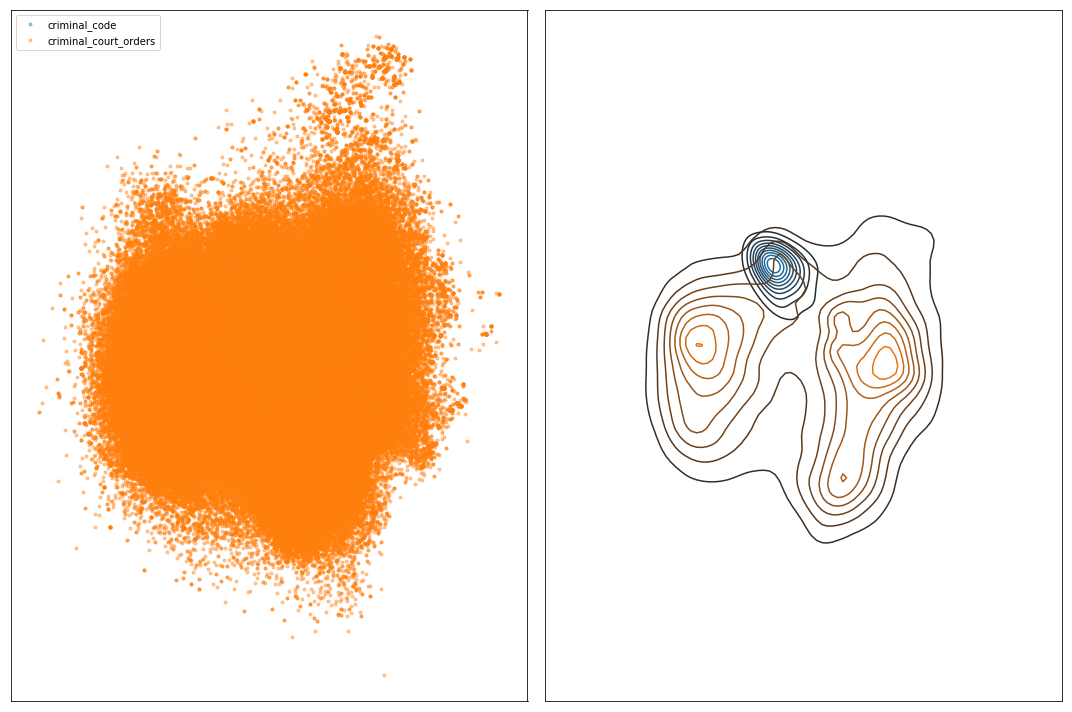

In [508]:
METHOD = 'pca'
DISPLAY = s['source'].unique()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 10), sharex='all', sharey='all')

for source in s['source'].unique():
    if source in DISPLAY:
        tmp = np.array(s[s['source'] == source][METHOD].tolist())
        ax1.scatter(tmp[:, 0], tmp[:, 1], marker='.', label=source, alpha=.4)
        ax2 = sns.kdeplot(tmp[:, 0], tmp[:, 1], ax=ax2, legend=False, shade_lowest=False)
    
ax1.legend()
ax1.tick_params(axis='both', which='both', left=False, bottom=False, labelleft=False, labelbottom=False)
ax2.tick_params(axis='both', which='both', left=False, bottom=False, labelleft=False, labelbottom=False)

plt.tight_layout()
plt.autoscale()
plt.show()

In [ ]:
cc = (
    s[s["source"] == "criminal_code"]
    .groupby("name")
    .agg({"number": "first", "sent": list, "source": "first", "fasttext": list})
    .reset_index(drop=False)
)
co = (
    s[s["source"] == "criminal_court_orders"]
    .groupby("name")
    .agg({"labels": "first", "sent": list, "source": "first", "fasttext": list})
    .reset_index(drop=False)
)


In [ ]:
cc.head()

## Расстояние 
Построим следующую метрику:

Есть два текста $a$ и $b$, состоящие из предложений $a_1, a_2, ..., a_N$ и $b_1, b_2, ..., b_M$ соответственно, представленных в некотором пространстве. 

Задана мера расстояния $d_{i, j}$ между двумя предложениями. 

Расстоянием от текста $a$ до текста $b$ будем называть выражение

$$
\rho_{a, b} = \frac{1}{N}\sum^{N}_{i=1} \min_{j=1,...,M} d_{i, j}
$$



In [510]:
def text_distance(text_a, text_b, sent_dist=scipy.spatial.distance.cosine):
    """Calculate distance between two embedded texts.
    params:
        text_a - first text
        text_b - second text
        sent_dist - function that takes two arguments - two vectors and calculate distance between them.
    """
    dist = np.zeros((len(text_a), len(text_b)))
    for i, sent_a in enumerate(text_a):
        for j, sent_b in enumerate(text_b):
            dist[i, j] = sent_dist(sent_a, sent_b)
    return dist.min(axis=1).sum() / len(text_a)

In [378]:
# %%time 

# distances = np.zeros((cc.shape[0], co.shape[0]))

# for i, text_a in cc['fasttext'].iteritems():
#     for j, text_b in co['fasttext'].iteritems():
#         distances[i, j] = text_distance(text_a, text_b, )

In [514]:
co_sample = co.sample(100).copy()

In [515]:
distances = np.zeros((co_sample.shape[0], cc.shape[0]))

for i, (_, text_a) in enumerate(co_sample['fasttext'].iteritems()):
    if i % 10 == 0:
        print( i, "rows processed")
    for j, text_b in cc['fasttext'].iteritems():
        distances[i, j] = text_distance(text_a, text_b, )

0 rows processed
10 rows processed
20 rows processed
30 rows processed
40 rows processed
50 rows processed
60 rows processed
70 rows processed
80 rows processed
90 rows processed


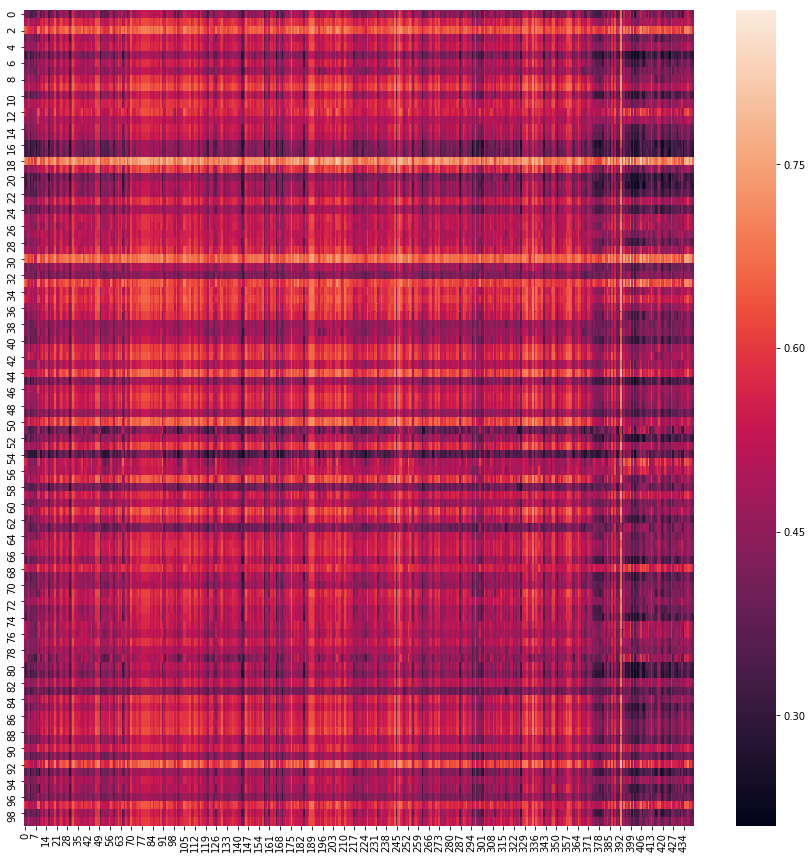

In [516]:
plt.subplots(1, 1, figsize=(15, 15))
sns.heatmap(distances)
# plt.savefig("distance.png")

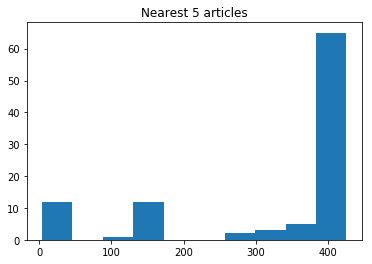

In [517]:
plt.hist(np.argmin(distances, axis=1))
plt.title("Nearest 5 articles")
plt.show()

15 статей самых ближайших статей УК

In [518]:
tmp = np.array(np.unique(np.argpartition(distances, kth=5)[:, :5].flatten(), return_counts=True)).T
for x in np.array(sorted(tmp, key=lambda x: x[1], reverse=True))[:, 0][:5]:
    print(cc["name"].iloc[x])

Ст.61.0 Обстоятельства, смягчающие наказание
Ст.63.0 Обстоятельства, отягчающие наказание
Ст.64.0 Назначение более мягкого наказания, чем предусмотрено за данное преступление
Ст.20.0 Возраст, с которого наступает уголовная ответственность
Ст.82.1 Отсрочка отбывания наказания больным наркоманией


In [519]:
co_sample["labels"] = co_sample['labels'].map(lambda x: list(map(float, x.split())))

In [520]:
def averaged_accuracy(y_true, y_pred):
    return len(set(y_true) & set(y_pred)) / len(set(y_true) | set(y_pred))

def exact_accuracy(y_true, y_pred):
    return 1 if set(y_true) == set(y_pred) else 0

def weak_accuracy(y_true, y_pred):
    return 1 if set(y_true) & set(y_pred) else 0

In [521]:
results = []

for N in range(cc.shape[0]):
    targets = []
    for i in range(co_sample.shape[0]):
        targets.append(cc.iloc[np.argpartition(distances, kth=N)[:, :N][i]]['number'].tolist())

    co_sample['targets'] = targets
    av_res = co_sample.apply(lambda row: averaged_accuracy(row["targets"], row["labels"]), axis=1).mean()
    exact_res = co_sample.apply(lambda row: exact_accuracy(row["targets"], row["labels"]), axis=1).mean()
    weak_res = co_sample.apply(lambda row: weak_accuracy(row["targets"], row["labels"]), axis=1).mean()
    
    results.append((N, av_res, exact_res, weak_res))
results = np.array(results)

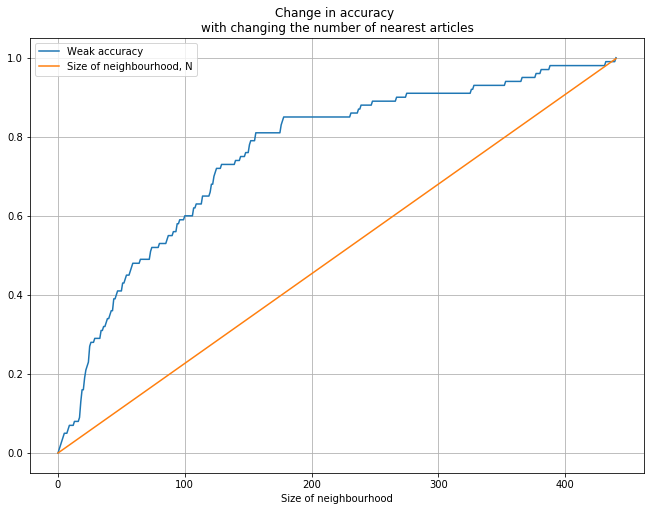

In [524]:
plt.figure(figsize=(11,8))
# plt.plot(results[:, 1], label="Accuracy")
# plt.plot(results[:, 2], label="Exact accuracy")
plt.plot(results[:, 3], label="Weak accuracy")
plt.plot(results[:, 0] / cc.shape[0], label="Size of neighbourhood, N")
plt.title("Change in accuracy \nwith changing the number of nearest articles")
plt.legend()
plt.xlabel("Size of neighbourhood")
plt.ylabel("")
plt.grid()
plt.show()

# doc2vec

In [ ]:
td = lambda row: gensim.models.doc2vec.TaggedDocument(words=row['lemmas'].split(), tags=[row.name])
documents = df.apply(td, axis=1).tolist()
gensim.utils.save_as_line_sentence(df['lemmas'].str.split(), 'all/tmp_lemmas.txt')

In [ ]:
%%time
doc2vec = gensim.models.doc2vec.Doc2Vec(corpus_file='all/tmp_lemmas.txt', epochs=300, vector_size=300, workers=8)
df['doc2vec'] = doc2vec.docvecs.vectors_docs.tolist()

# Plots

In [48]:
df['pca'] = PCA(2).fit_transform(df['doc2vec'].tolist()).tolist()

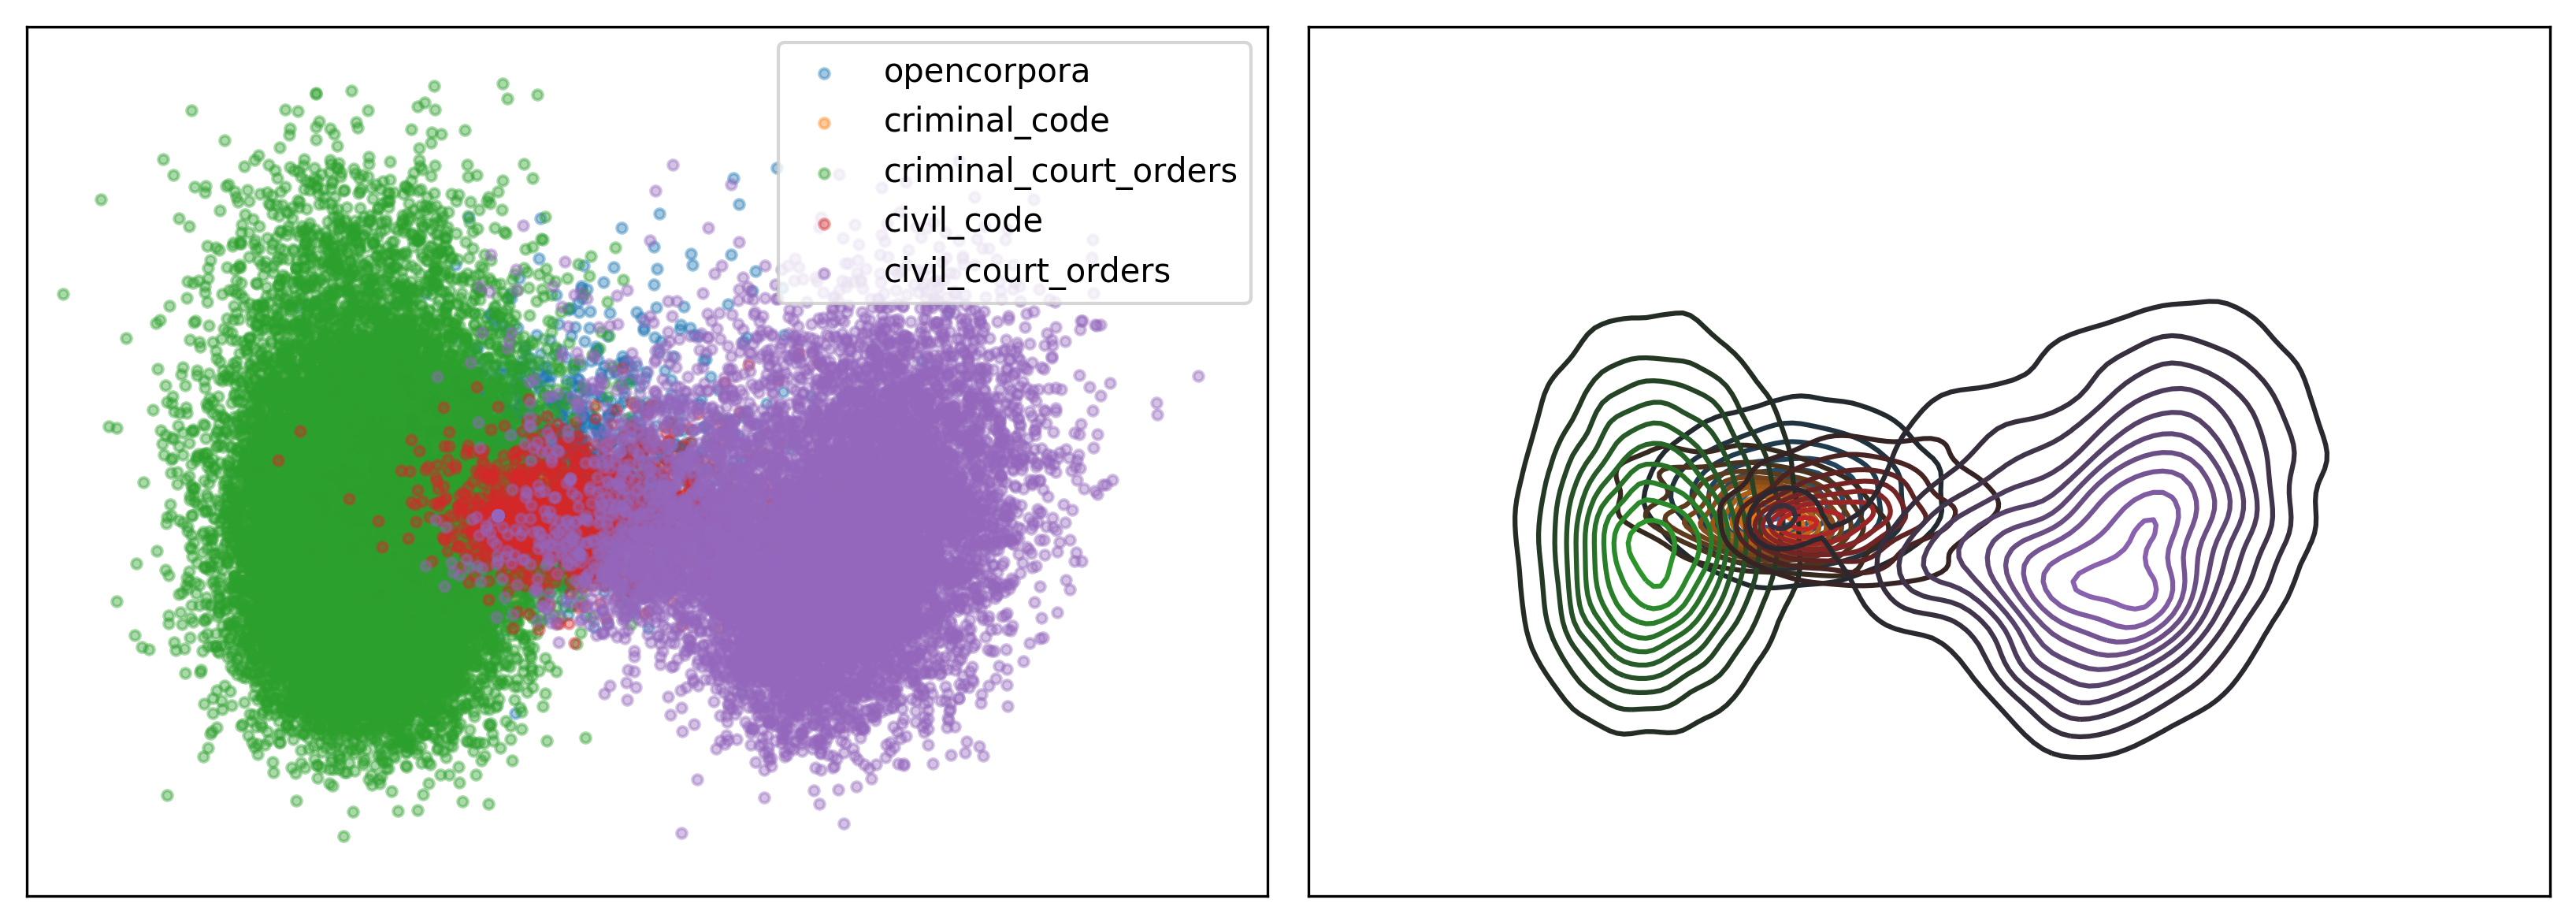

In [49]:
METHOD = 'pca'
DISPLAY = df['source'].unique()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11, 4), dpi=300, sharex='all', sharey='all')

for source in df['source'].unique():
    if source in DISPLAY:
        tmp = np.array(df[df['source'] == source][METHOD].tolist())
        ax1.scatter(tmp[:, 0], tmp[:, 1], marker='.', label=source, alpha=.4)
        ax2 = sns.kdeplot(tmp[:, 0], tmp[:, 1], ax=ax2, legend=False, shade_lowest=False)
    
ax1.legend()
ax1.tick_params(axis='both', which='both', left=False, bottom=False, labelleft=False, labelbottom=False)
ax2.tick_params(axis='both', which='both', left=False, bottom=False, labelleft=False, labelbottom=False)

plt.tight_layout()
plt.autoscale()
plt.show()

In [222]:
s['pca'] = PCA(2).fit_transform(s['fasttext'].tolist()).tolist()

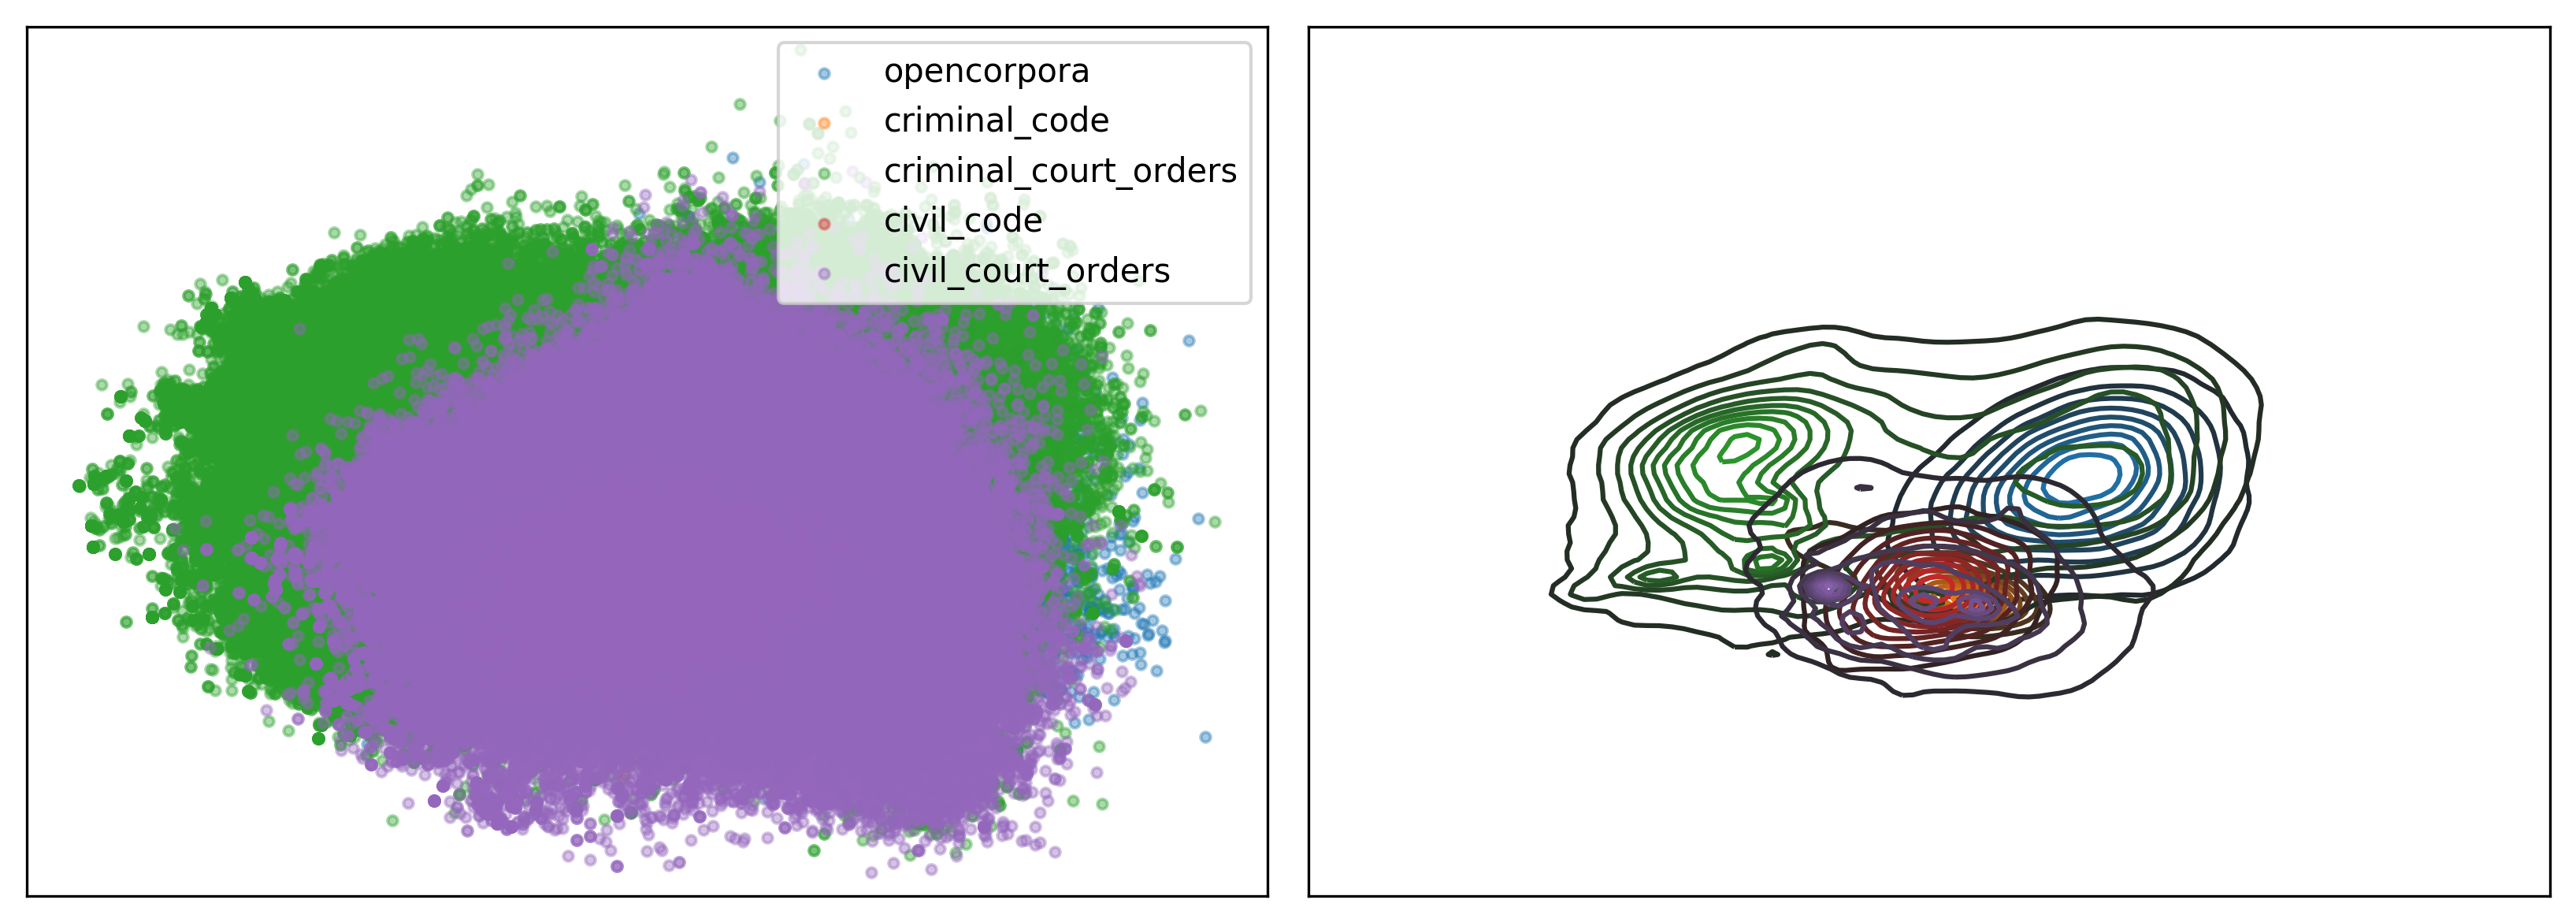

In [226]:
METHOD = 'pca'
DISPLAY = s['source'].unique()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11, 4), dpi=300, sharex='all', sharey='all')

for source in s['source'].unique():
    if source in DISPLAY:
        tmp = np.array(s[s['source'] == source][METHOD].tolist())
        ax1.scatter(tmp[:, 0], tmp[:, 1], marker='.', label=source, alpha=.4)
        ax2 = sns.kdeplot(tmp[:, 0], tmp[:, 1], ax=ax2, legend=False, shade_lowest=False)
    
ax1.legend()
ax1.tick_params(axis='both', which='both', left=False, bottom=False, labelleft=False, labelbottom=False)
ax2.tick_params(axis='both', which='both', left=False, bottom=False, labelleft=False, labelbottom=False)

plt.tight_layout()
plt.autoscale()
plt.show()